In [33]:
import glob
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import random


In [14]:
f_list = glob.glob('*_data_df.p')
df_list = []
for fname in f_list:
    if 'jupyter' not in fname:
        df_list.append(pickle.load(open( fname, 'rb' )))
#print(df_list[5])

In [15]:
full_feature_df= pd.concat(df_list)

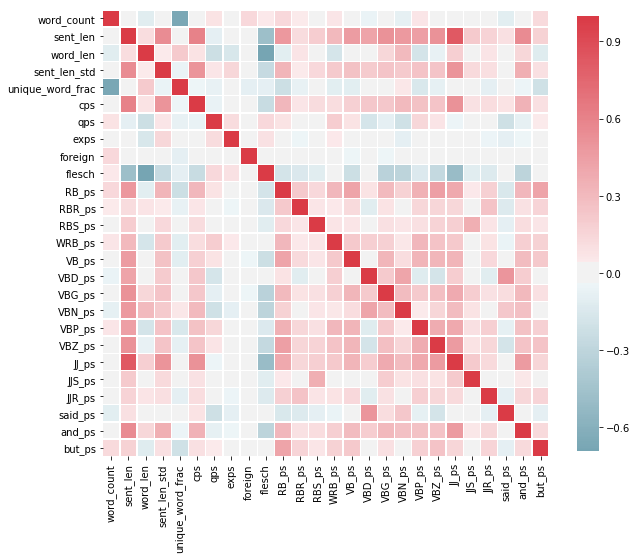

In [28]:
feat_list = ['word_count', 'sent_len', 'word_len', 'sent_len_std', 'unique_word_frac', 
             'cps', 'qps', 'exps', 'foreign', 'flesch',  
             'RB_ps', 'RBR_ps', 'RBS_ps', 'WRB_ps', 'VB_ps', 
             'VBD_ps', 'VBG_ps', 'VBN_ps', 'VBP_ps', 'VBZ_ps', 'JJ_ps', 'JJS_ps', 'JJR_ps',
             'said_ps', 'and_ps', 'but_ps']

#full_feature_df = pd.concat(df_list)



import matplotlib.ticker as ticker
corr = full_feature_df[feat_list].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(10,10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,cmap=cmap, center=0,
            square=True, linewidths=.3, cbar_kws={"shrink": .8})




full_feature_df[feat_list].head()

min_word_count = 0

feature_array = full_feature_df.loc[(full_feature_df['word_count'] > min_word_count)][feat_list].values
label_array =   full_feature_df.loc[(full_feature_df['word_count'] > min_word_count)]['label'].values
#print(full_feature_df[feat_list][(full_feature_df >= 0).all(1)].head())

article_counts = full_feature_df.groupby('label')['label'].count().tolist()

In [29]:
#combine features
#X = [[i, j, k, l, m, n, o] for i, j, k, l, m, n, o in zip(
#    sent_len_std, unique_word_frac, word_len, cps, qps, exps, flesch)]#, sup_adv_ps, verb_ps, sent_compound)]
#feature_names = ['sentence variability', 'unique word fraction', 
#                 'mean word length', 'commas per sentence', 'questions per sentence', 
#                 'exclamations per sentence', 'flesch']#, 'adverbs per sentence', 
                 #'verbs per sentence', 'sent_compound']



X = feature_array
feature_names = feat_list
Y = label_array

n_samples = len(X)

data_boundaries = article_counts
#data_boundaries = [n_articles for i in [nyt, breit, wapo, guard]]
print(data_boundaries)
cumulative_bounds = [0]
for ci, i in enumerate(data_boundaries):
    cumulative_bounds.append(i+cumulative_bounds[ci])
print(cumulative_bounds)
#cumulative_bounds = [0]
#cumulative_bounds = [cumulative_bounds[i-1] + i for i in data_boundaries]
print(len(X))
#X = np.asarray(wc).reshape(-1,1)

#labels
#Y = [0 for i in range(len(nyt_feature_df.word_count))] + \
#    [1 for i in range(len(breit_feature_df.word_count))] + \
#    [2 for i in range(len(wapo_feature_df.word_count))] + \
#    [3 for i in range(len(guard_feature_df.word_count))]
#Y = [0 for i in range(n_articles)] + [1 for i in range(n_articles)] + [2 for i in range(n_articles)] + [3 for i in range(n_articles)]
print(len(Y))


[4989, 4919, 4835, 4348, 4884, 4943, 4976, 4947, 4956]
[0, 4989, 9908, 14743, 19091, 23975, 28918, 33894, 38841, 43797]
43797
43797


In [34]:
#test train split
from sklearn.model_selection import train_test_split

indices = np.arange(n_samples)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, Y, indices, test_size=0.1)
print(idx_train)
print(idx_test)

#text_list = nyt_sent + breit_sent + wapo_sent +guard_sent
#print(len(text_list))

[38202 27385 18637 ... 43173 35594  8852]
[41248   125 18665 ... 10035   694 11575]


In [35]:
#from sklearn.model_selection import GridSearchCV
#parameters = {'max_depth':range(3,20)}
#clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
#clf.fit(X=X_train, y=y_train)
#tree_model = clf.best_estimator_
#print (clf.best_score_, clf.best_params_) 


#clf = tree.DecisionTreeClassifier(max_depth = 5)
#clf = clf.fit(X_train, y_train)

from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=20)
for i in range(100,4500, 400):
    rand_start = random.randint(0,4500 - i)
    rf_clf = rf_clf.fit(X_train[rand_start:rand_start + i], y_train[rand_start:rand_start + i])

    print(rf_clf.score(X_test, y_test))
rf_clf = rf_clf.fit(X_train, y_train)
print(rf_clf.score(X_test, y_test))

y_pred = rf_clf.predict(X_test)
#chance = [0 if random.random() > 0.5 else 1 for _ in range(len(y_pred))]

0.2232876712328767
0.31666666666666665
0.31894977168949773
0.3360730593607306
0.3376712328767123
0.3582191780821918
0.3607305936073059
0.3550228310502283
0.367351598173516
0.3639269406392694
0.37579908675799084
0.4374429223744292


In [36]:
from sklearn.ensemble import GradientBoostingClassifier

xg_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.25,
                                 max_depth=5, random_state=0).fit(X_train, y_train)
print(xg_clf.score(X_test, y_test))

y_pred = xg_clf.predict(X_test)


0.47054794520547943


Normalized confusion matrix
[[0.4  0.07 0.06 0.04 0.07 0.13 0.05 0.11 0.08]
 [0.04 0.48 0.1  0.11 0.07 0.08 0.01 0.05 0.06]
 [0.05 0.16 0.43 0.09 0.07 0.02 0.07 0.04 0.06]
 [0.02 0.15 0.08 0.43 0.08 0.05 0.06 0.03 0.08]
 [0.07 0.07 0.1  0.1  0.35 0.07 0.08 0.06 0.09]
 [0.14 0.06 0.01 0.01 0.04 0.58 0.01 0.08 0.08]
 [0.04 0.03 0.06 0.03 0.06 0.01 0.65 0.04 0.08]
 [0.1  0.06 0.04 0.02 0.05 0.12 0.01 0.56 0.05]
 [0.07 0.08 0.08 0.06 0.07 0.13 0.11 0.07 0.34]]


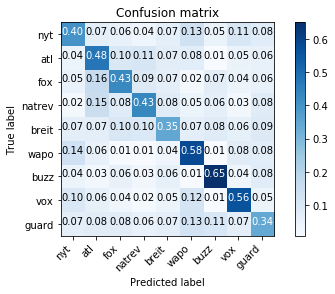

In [41]:
from sklearn.metrics import confusion_matrix
import itertools
class_names = [i.loc[0,'label'] for i in df_list]#['New York Times', 'Breitbart', 'Washington Post', 'Guardian']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha = 'right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix', normalize = True)


Feature ranking:
1. feature 0 (0.080577)
2. feature 4 (0.080029)
3. feature 2 (0.057969)
4. feature 23 (0.057882)
5. feature 9 (0.055543)
6. feature 3 (0.055066)
7. feature 5 (0.051411)
8. feature 1 (0.048202)
9. feature 15 (0.044038)
10. feature 10 (0.039827)
11. feature 14 (0.038817)
12. feature 17 (0.037893)
13. feature 19 (0.036762)
14. feature 18 (0.036601)
15. feature 20 (0.033825)
16. feature 24 (0.031750)
17. feature 16 (0.030677)
18. feature 25 (0.026301)
19. feature 22 (0.025435)
20. feature 11 (0.024273)
21. feature 13 (0.023853)
22. feature 6 (0.022246)
23. feature 21 (0.021734)
24. feature 12 (0.015913)
25. feature 7 (0.014189)
26. feature 8 (0.009189)
[ 0  4  2 23  9  3  5  1 15 10 14 17 19 18 20 24 16 25 22 11 13  6 21 12
  7  8]


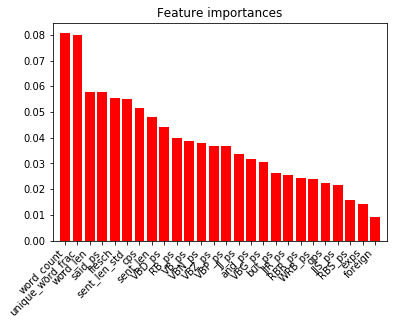

In [42]:
importances = xg_clf.feature_importances_
#std = np.std([tree.feature_importances_ for tree in xg_clf.estimators_],
#             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(X[0])):#.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(X[0])), importances[indices],
       color="r", align='center')#, yerr=std[indices], align="center")
print(indices)
plt.xticks(range(len(X[0])), [feature_names[i] for i in indices], rotation = 45, ha = 'right')
plt.xlim([-1, len(X[0])])
plt.show()


In [ ]:
conf_mat = np.zeros((4,4))
count = 0
for pred, true in zip(y_pred, y_test):
    if pred == 0 and true == 3:
            print(pred, true, count, 'mismatch')
            print(' '.join(text_list[idx_test[count]]))
            input()
    conf_mat[pred,true] += 1.
    count += 1
print(count)
#conf_mat[2,1] += 1000
#[y,x] format (first index (predicted) is on the vertical, second index (truth) is on the horizontal)
plt.imshow(conf_mat)
plt.colorbar()
print(conf_mat, np.sum(conf_mat))
print(Counter(y_test))